In this notebook I will apply the LSTM model into the data which was prepared in R.

### 1. Importing the libraries

In [229]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout

### 2. Importing the dataset

In [2]:
fludat_pivot = pd.read_csv('./dataset/Flu_pivot.csv')

In [3]:
fludat_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sdate      546 non-null    object
 1   Processed  546 non-null    int64 
 2   A_total    546 non-null    int64 
 3   B_total    546 non-null    int64 
 4   All_total  546 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 21.5+ KB


In [4]:
# Parsing to datetime
fludat_pivot['sdate'] = pd.to_datetime(fludat_pivot['sdate'])

### 3. Data understanding

In [5]:
fludat_pivot.head()

,sdate,Processed,A_total,B_total,All_total
0,2010-01-04,9312,1999,1,2000
1,2010-01-11,10728,1404,15,1419
2,2010-01-18,9027,1135,49,1184
3,2010-01-25,8030,515,18,533
4,2010-02-01,7788,502,14,516


In [135]:
# Extract year,month,day from date
fludat_pivot['year'] = fludat_pivot['sdate'].dt.year
fludat_pivot['month'] = fludat_pivot['sdate'].dt.month
fludat_pivot['day'] = fludat_pivot['sdate'].dt.day

In [137]:
fludat_pivot.head()

,sdate,Processed,A_total,B_total,All_total,year,month,day
0,2010-01-04,9312,1999,1,2000,2010,1,4
1,2010-01-11,10728,1404,15,1419,2010,1,11
2,2010-01-18,9027,1135,49,1184,2010,1,18
3,2010-01-25,8030,515,18,533,2010,1,25
4,2010-02-01,7788,502,14,516,2010,2,1


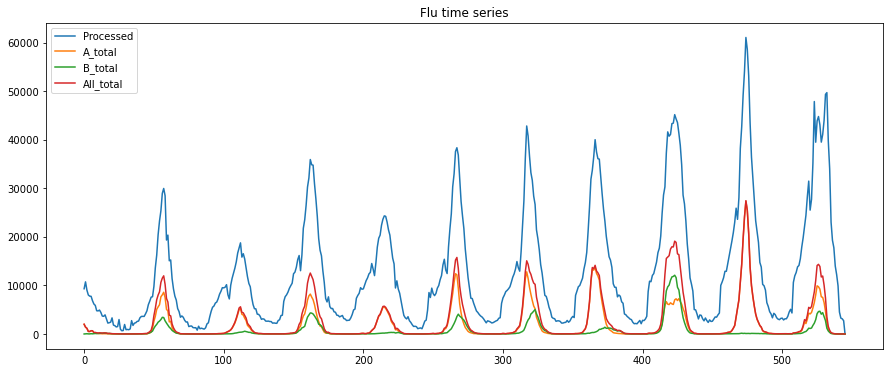

In [164]:
# Check the data through line plot
plt.figure(figsize=(15,6))
plt.plot(fludat_pivot[['Processed','A_total','B_total','All_total']])
plt.legend(['Processed','A_total','B_total','All_total'])
plt.title('Flu time series')
plt.show()

In [191]:
# Pivot table to check the average of each month (Positive cases)
fludat_pivot.groupby(['month'], as_index=False)['All_total'].mean()

,month,All_total
0,1,8640.625000
1,2,10849.133333
2,3,5264.041667
3,4,1551.791667
4,5,283.916667
5,6,50.911111
6,7,22.044444
7,8,18.250000
8,9,29.279070
9,10,112.044444


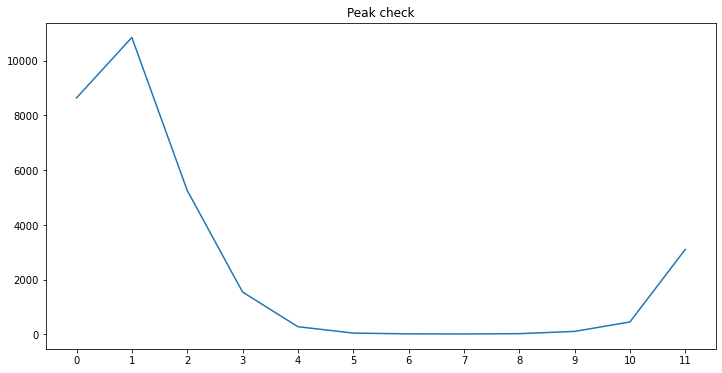

In [179]:
# Which month is the peak in average
plt.figure(figsize=(12,6))
plt.plot(fludat_pivot.groupby(['month'], as_index=False)['All_total'].mean()['All_total'])
plt.xticks(fludat_pivot.groupby(['month'], as_index=False)['All_total'].mean().index)
plt.title('Peak check')
plt.show()

Peak is around december january february

In [192]:
# Series
forecast_data = fludat_pivot.set_index(fludat_pivot['sdate'])['All_total']
forecast_data.name = 'Positive_cases'
forecast_data

sdate
2010-01-04    2000
2010-01-11    1419
2010-01-18    1184
2010-01-25     533
2010-02-01     516
              ... 
2020-05-18       3
2020-05-25       3
2020-06-01       1
2020-06-08       4
2020-06-15       0
Name: Positive_cases, Length: 546, dtype: int64

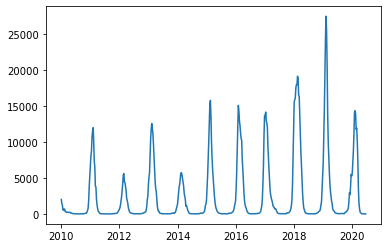

In [9]:
# Plot series
plt.plot(forecast_data)

### 4. Data preparation for modeling

In [11]:
# Splitting the dataset into train and test 80% - 20%

train_size = int(len(forecast_data)*0.8)
test_size = len(forecast_data)-train_size

training_data = np.array(forecast_data[0:train_size])
test_data = np.array(forecast_data[train_size:len(forecast_data)])

In [12]:
 # LSTM are sensitive to the scale of the data, so we apply minmax scaler
scaler = MinMaxScaler(feature_range=(0,1))

# Scaled array
training_data_scaled = scaler.fit_transform(training_data.reshape(-1,1))
test_data_scaled = scaler.transform(test_data.reshape(-1,1))

In [13]:
training_data_scaled.shape

(436, 1)

In [14]:
test_data_scaled.shape

(110, 1)

In [15]:
# Within the 'training_data' and 'test_data', we create x_train,x_test, y_train, y_test

def create_data(dataset, time_step = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        data_X.append(a.tolist())
        data_Y.append(dataset[i + time_step, 0].tolist())
    return np.array(data_X), np.array(data_Y)

In [16]:
# time_step hyperparameter tuning
time_step = 3

X_train, y_train = create_data(training_data_scaled, time_step)
X_test, y_test = create_data(test_data_scaled, time_step)

In [17]:
print('X_train shape: ',X_train.shape, ', y_train shape: ',y_train.shape)
print('------------------------')
print('X_test shape: ',X_test.shape, ', y_test shape: ',y_test.shape)

X_train shape:  (432, 3) , y_train shape:  (432,)
------------------------
X_test shape:  (106, 3) , y_test shape:  (106,)


### 5. Modeling

We are gonna use different LSTM architectures..

In [18]:
# for LSTM we need to add an additional dimension
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#### a) LSTM layer (32 neurons) - Dropout - Output

In [113]:
# Create stack LSTM model
model = Sequential()
model.add(LSTM(32, input_shape = (3,1)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [114]:
EPOCHS = 30
H = model.fit(X_train,y_train, epochs = EPOCHS, batch_size = 1, validation_split=0.25, shuffle=False, verbose = 1)

Epoch 1/30
324/324 [==============================] - 2s 3ms/step - loss: 0.0123 - val_loss: 0.0154
Epoch 2/30
324/324 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0140
Epoch 3/30
324/324 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0124
Epoch 4/30
324/324 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0113
Epoch 5/30
324/324 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0099
Epoch 6/30
324/324 [==============================] - 1s 2ms/step - loss: 0.0034 - val_loss: 0.0085
Epoch 7/30
324/324 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.0066
Epoch 8/30
324/324 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0051
Epoch 9/30
324/324 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 10/30
324/324 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0045

In [115]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


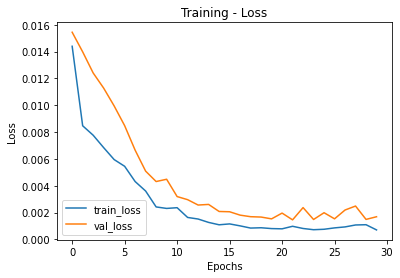

In [116]:
N = EPOCHS

plt.plot(np.arange(0, N), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, N), H.history['val_loss'], label='val_loss')
plt.title('Training - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.savefig("./plot/LSTM_model_training_plot.png")

In [117]:
# Prediction
y_pred = model.predict(X_test)

In [119]:
y_pred_realval = scaler.inverse_transform(y_pred)

In [120]:
lstm_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Scaled RMSE: ',lstm_rmse)
print('Inverse scaled RMSE: ', scaler.inverse_transform(np.array(lstm_rmse).reshape(1,-1))[0][0])

Scaled RMSE:  0.0575557958539093
Inverse scaled RMSE:  1101.8337029723527


In [121]:
print(y_pred_realval.shape)
print(np.array(forecast_data).reshape(len(forecast_data),1).shape)

(106, 1)
(546, 1)


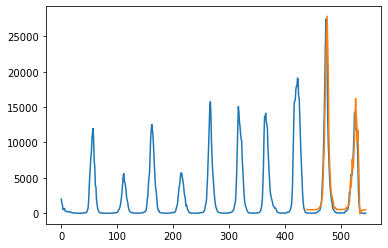

In [122]:
# Plotting
test_predict = np.empty_like(np.array(forecast_data).reshape(len(forecast_data),1))
test_predict[:,:] = np.nan
test_predict = np.where(test_predict == -9223372036854775808, np.nan, test_predict)
test_predict[546-106:,:] = y_pred_realval
plt.plot(np.array(forecast_data).reshape(len(forecast_data),1))
plt.plot(test_predict)

#### b) Bidirectional LSTM

In [106]:
model = Sequential()
model.add(Bidirectional(LSTM(units=32, input_shape=(3,1))))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### 6. Forecasting

### Predicting the next peak

In [182]:
# Last observation
forecast_data.tail(1).index[0]

Timestamp('2020-06-15 00:00:00')

Above we saw that the peak is around 12,01,02, so we are going to predict the next 8 months.

In [123]:
len(test_data)

110

In [292]:
# We need the last 3 value from the test data to start the prediction
x_input = test_data_scaled[len(test_data_scaled)-3:].reshape(1,-1)

# x_input to list
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# prediction_array
prediction_arr = x_input.reshape(3,1)

# find next 32 (8 months == 32 weeks) value
output = []
time_step = 3
i = 0

while(i<32):
    if(len(temp_input)>3):
        # last 3 element after the first loop
        x_input = np.array(temp_input[1:])
        #reshaping
        x_input = x_input.reshape(1, time_step, 1)
        # predict
        y_hat = model.predict(x_input, verbose = 0)
        
        # add to final pred arr
        temp_arr = np.vstack((x_input[:,1:].reshape(2,1),y_hat))
        prediction_arr = np.append(prediction_arr,temp_arr.reshape(1,3,1), axis=0)
        
        # adding to the temp list
        temp_input.append(y_hat[0][0].tolist())
        # change temp list to the last 3 value
        temp_input = temp_input[1:]
        # add prediction to output
        output.append(y_hat[0][0].tolist())
        i = i+1
    
    else:
        # last 3 value reshape and predict
        x_input = x_input.reshape(1, time_step, 1)
        y_hat = model.predict(x_input, verbose = 0)
        
        # add to final prediction arr
        temp_arr = np.vstack((x_input[:,1:].reshape(2,1),y_hat))
        prediction_arr = np.stack((prediction_arr,temp_arr))
        
        # adding the value to temp input list
        temp_input.append(y_hat[0][0].tolist())
        # adding the value to output list
        output.append(y_hat[0][0].tolist())
        i = i+1

prediction_arr = prediction_arr.reshape(prediction_arr.shape[0],prediction_arr.shape[1],1)
print(output)
print('---------------------------------')
print(prediction_arr)

[0.024866260588169098, 0.0633808821439743, 0.1238301619887352, 0.20749890804290771, 0.31859102845191956, 0.4553428888320923, 0.6065812706947327, 0.7461326122283936, 0.8393996953964233, 0.8673058152198792, 0.8460144400596619, 0.8083953857421875, 0.7718611359596252, 0.7370954155921936, 0.7015198469161987, 0.6644870042800903, 0.6266981959342957, 0.5892954468727112, 0.5535897016525269, 0.5209828615188599, 0.4928675889968872, 0.47049468755722046, 0.45483434200286865, 0.4464512765407562, 0.4454062283039093, 0.451190710067749, 0.46270227432250977, 0.478279709815979, 0.49582818150520325, 0.5130581259727478, 0.5278247594833374, 0.5384902954101562]
---------------------------------
[[[-5.23313622e-05]
  [ 1.04662724e-04]
  [-1.04662724e-04]]

 [[ 1.04662724e-04]
  [-1.04662724e-04]
  [ 2.48662606e-02]]

 [[-1.04662724e-04]
  [ 2.48662606e-02]
  [ 6.33808821e-02]]

 [[ 2.48662606e-02]
  [ 6.33808821e-02]
  [ 1.23830162e-01]]

 [[ 6.33808821e-02]
  [ 1.23830162e-01]
  [ 2.07498908e-01]]

 [[ 1.238

In [293]:
y_pred_2yrs = model.predict(prediction_arr)
y_pred_2yrs = scaler.inverse_transform(y_pred_2yrs)

In [294]:
print(len(forecast_data))
print(len(y_pred_2yrs))

546
33


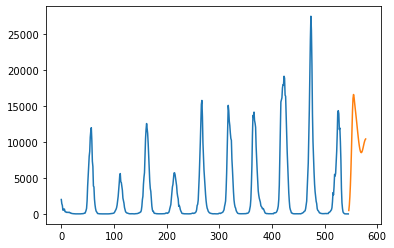

In [295]:
plt.plot(np.arange(0,546),forecast_data)
plt.plot(np.arange(546,546+33),y_pred_2yrs)

In [296]:
last_date = fludat_pivot.tail(1)['sdate']
yhat_temp = y_pred_2yrs.reshape(len(y_pred_2yrs),)
dates = []

for i in range(len(yhat_temp)):
    last_date = last_date + datetime.timedelta(days=7)
    dates.append(last_date)

In [297]:
df_pred = pd.DataFrame({'Dates':dates,
                        'Predicted_value':yhat_temp})

In [298]:
df_pred.head()

,Dates,Predicted_value
0,"545 2020-06-22 Name: sdate, dtype: datetime6...",477.169495
1,"545 2020-06-29 Name: sdate, dtype: datetime6...",1213.145020
2,"545 2020-07-06 Name: sdate, dtype: datetime6...",2368.270508
3,"545 2020-07-13 Name: sdate, dtype: datetime6...",3967.096680
4,"545 2020-07-20 Name: sdate, dtype: datetime6...",6089.956055


In [299]:
df_pred['Dates'] = df_pred['Dates'].apply(lambda x: str(x).split(' ')[3].replace('\nName:',''))
df_pred['Dates'] = pd.to_datetime(df_pred['Dates'])

df_pred.head()

,Dates,Predicted_value
0,2020-06-22,477.169495
1,2020-06-29,1213.145020
2,2020-07-06,2368.270508
3,2020-07-13,3967.096680
4,2020-07-20,6089.956055


In [300]:
df_pred.loc[df_pred['Predicted_value'] == max(df_pred['Predicted_value'])]

,Dates,Predicted_value
9,2020-08-24,16575.345703


In [304]:
fludat_pivot.tail()

,sdate,Processed,A_total,B_total,All_total,year,month,day
541,2020-05-18,4516,1,2,3,2020,5,18
542,2020-05-25,3262,1,2,3,2020,5,25
543,2020-06-01,3122,1,0,1,2020,6,1
544,2020-06-08,2734,2,2,4,2020,6,8
545,2020-06-15,0,0,0,0,2020,6,15


In [305]:
X_test

array([[[ 2.01475744e-02],
        [ 7.27405934e-03],
        [ 7.16939662e-03]],

       [[ 7.27405934e-03],
        [ 7.16939662e-03],
        [ 3.19221309e-03]],

       [[ 7.16939662e-03],
        [ 3.19221309e-03],
        [ 1.83159768e-03]],

       [[ 3.19221309e-03],
        [ 1.83159768e-03],
        [ 1.30828405e-03]],

       [[ 1.83159768e-03],
        [ 1.30828405e-03],
        [ 9.41964519e-04]],

       [[ 1.30828405e-03],
        [ 9.41964519e-04],
        [ 8.89633157e-04]],

       [[ 9.41964519e-04],
        [ 8.89633157e-04],
        [ 6.27976346e-04]],

       [[ 8.89633157e-04],
        [ 6.27976346e-04],
        [ 1.04662724e-03]],

       [[ 6.27976346e-04],
        [ 1.04662724e-03],
        [ 6.27976346e-04]],

       [[ 1.04662724e-03],
        [ 6.27976346e-04],
        [ 1.20362133e-03]],

       [[ 6.27976346e-04],
        [ 1.20362133e-03],
        [ 6.80307708e-04]],

       [[ 1.20362133e-03],
        [ 6.80307708e-04],
        [ 8.37301795e-04]],

    

In [309]:
test_data_scaled[-3:]

array([[-5.23313622e-05],
       [ 1.04662724e-04],
       [-1.04662724e-04]])

In [312]:
scaler.inverse_transform(model.predict(test_data_scaled[-3:].reshape(1,3,1),verbose=0))

array([[477.16937]], dtype=float32)